In [137]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
import numpy as np
import time
import pandas as pd
from geopy.geocoders import Nominatim
import math
from matplotlib import pyplot
import re



In [37]:
tweets = pd.read_csv("data/train_pre_processing.csv")

# Pruebas solo con variables numéricas y booleanas

In [3]:
x_features, target = tweets.select_dtypes(include=['float64','int64','bool']).iloc[:,:-1],tweets.iloc[:,-1]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_features, target, test_size=0.2, random_state=123)

# Pruebas con valores por default del LGBMClassifier

In [5]:
start = time.time()
light_model = LGBMClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()


print('Accuracy: %.3f (std :%.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end-start)/60))


Accuracy: 0.693 (std :0.017). Time: 0.19


# Pruebas descartando una columna (todas las combinaciones)

In [17]:
x_train_columns = {}

for x in range(0,30):
    column_list = []
    for y in range(0,30):
        if y != x:
            column_list.append(y)
    x_train_columns[x] = column_list

def get_dic_acc():
    results = {}
    results['accuracy'] = []
    results['std'] = []
    results['time'] = []
    
    return results

In [7]:
no_column = get_dic_acc()
index_no_column = []


for x in range(0,30):
    start = time.time()

    light_model = LGBMClassifier(random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)
    x_train_2 = x_train.iloc[:,x_train_columns[x]]
    n_scores = cross_val_score(light_model, x_train_2, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    index_no_column.append(x_train.columns[x])
    no_column['accuracy'].append(np.mean(n_scores))
    no_column['std'].append(np.std(n_scores))
    no_column['time'].append((end - start)/60)

pd.DataFrame(no_column, index=index_no_column).nlargest(10,'accuracy')     


,accuracy,std,time
total_4_ormore_words,0.693974,0.016061,0.136329
subjectivity_text,0.693826,0.016843,0.126967
total_5_ormore_words,0.693695,0.016156,0.135257
total_6_orless_words,0.693580,0.016874,0.142286
total_7_ormore_words,0.693399,0.015039,0.134584
total_8_words,0.693350,0.016938,0.135639
total_5_words,0.693202,0.015872,0.135478
total_7_words,0.692742,0.015241,0.137700
total_words,0.692693,0.016329,0.136584
total_7_orless_words,0.692562,0.015567,0.138968


realizo una prueba eliminando aquellas columnas que no disminuyeron el resultado de Accuracy con tres decimales 

In [8]:
x_train_2 = x_train.drop(columns=['total_4_ormore_words','subjectivity_text','total_5_ormore_words','total_6_orless_words','total_7_ormore_words','total_8_words','total_5_words']) 

start = time.time()

light_model = LGBMClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)

n_scores = cross_val_score(light_model, x_train_2, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

print('ACC: %.3f (desv:  %.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end - start)/60))

ACC: 0.693 (desv:  0.016). Time: 0.12


# Pruebas variando parámetros según https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

# Pruebas variando n_estimators

In [9]:
n_estimators_best = 0
n_estimators_acc = 0
n_estimators_std = 0

n_estimators_dic = get_dic_acc()
index_n_estimators = []

for x in range(100,501,40):
    start = time.time()
    light_model = LGBMClassifier(random_state=1, n_estimators = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_n_estimators.append(x)
    n_estimators_dic['accuracy'].append(mean)
    n_estimators_dic['std'].append(np.std(std))
    n_estimators_dic['time'].append((end - start)/60)
    
    if (mean > n_estimators_acc) or (mean == n_estimators_acc and std < n_estimators_std): 
        n_estimators_best = x
        n_estimators_acc = mean
        n_estimators_std = std
 
    
print("Best n_estimators: %d" % (n_estimators_best))


Best n_estimators: 100


In [10]:
n_estimators_df = pd.DataFrame(n_estimators_dic, index=index_n_estimators).nlargest(20,'accuracy')
n_estimators_df

,accuracy,std,time
100,0.692775,0.0,0.138138
140,0.691445,0.0,0.177429
180,0.690345,0.0,0.214639
220,0.689261,0.0,0.251055
260,0.687882,0.0,0.288775
300,0.686141,0.0,0.336600
340,0.685107,0.0,0.394467
380,0.684762,0.0,0.428556
420,0.684433,0.0,0.481107
460,0.683826,0.0,0.516329


# Pruebas variando learning_rate

In [11]:
learning_rate_best = 0
learning_rate_acc = 0
learning_rate_std = 0

learning_rate_dic = get_dic_acc()
index_learning_rate = []

for x in range(1,11,1):
    start = time.time()
    x = x/100
    light_model = LGBMClassifier(random_state=1, n_estimators = n_estimators_best, learning_rate = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_learning_rate.append(x)
    learning_rate_dic['accuracy'].append(mean)
    learning_rate_dic['std'].append(np.std(std))
    learning_rate_dic['time'].append((end - start)/60)
    
    if (mean > learning_rate_acc) or (mean == learning_rate_acc and std < learning_rate_std): 
        learning_rate_best = x
        learning_rate_acc = mean
        learning_rate_std = std
 
    
print("Best learning_rate: %.3f" % (learning_rate_best))


Best learning_rate: 0.060


In [12]:
learning_rate_df = pd.DataFrame(learning_rate_dic, index=index_learning_rate).nlargest(20,'accuracy')
learning_rate_df

,accuracy,std,time
0.06,0.693777,0.0,0.143967
0.07,0.693580,0.0,0.141270
0.08,0.693547,0.0,0.137122
0.05,0.692791,0.0,0.145966
0.10,0.692775,0.0,0.138374
0.09,0.691970,0.0,0.140887
0.04,0.691856,0.0,0.148427
0.03,0.690164,0.0,0.155741
0.02,0.687373,0.0,0.158674
0.01,0.679967,0.0,0.166035


# Pruebas variando subsample


In [13]:
subsample_best = 0
subsample_acc = 0
subsample_std = 0

subsample_dic = get_dic_acc()
index_subsample = []

for x in range(1,11,1):
    start = time.time()
    x = x/10
    light_model = LGBMClassifier(random_state=1, n_estimators = n_estimators_best, learning_rate = learning_rate_best,subsample = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_subsample.append(x)
    subsample_dic['accuracy'].append(mean)
    subsample_dic['std'].append(np.std(std))
    subsample_dic['time'].append((end - start)/60)
    
    if (mean > subsample_acc) or (mean == subsample_acc and std < subsample_std): 
        subsample_best = x
        subsample_acc = mean
        subsample_std = std
 
    
print("Best subsample: %.2f" % (subsample_best))



Best subsample: 0.10


In [14]:
subsample_df = pd.DataFrame(subsample_dic, index=index_subsample).nlargest(20,'accuracy')
subsample_df


,accuracy,std,time
0.1,0.693777,0.0,0.150377
0.2,0.693777,0.0,0.144971
0.3,0.693777,0.0,0.147169
0.4,0.693777,0.0,0.141780
0.5,0.693777,0.0,0.142584
0.6,0.693777,0.0,0.144066
0.7,0.693777,0.0,0.145141
0.8,0.693777,0.0,0.143489
0.9,0.693777,0.0,0.143341
1.0,0.693777,0.0,0.141703


# Pruebas variando num_leaves


In [15]:
num_leaves_best = 0
num_leaves_acc = 0
num_leaves_std = 0

num_leaves_dic = get_dic_acc()
index_num_leaves = []

for x in range(21,42,2):
    start = time.time()
    light_model = LGBMClassifier(random_state=1, n_estimators = n_estimators_best, learning_rate = learning_rate_best,subsample = subsample_best, num_leaves = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_num_leaves.append(x)
    num_leaves_dic['accuracy'].append(mean)
    num_leaves_dic['std'].append(np.std(std))
    num_leaves_dic['time'].append((end - start)/60)
    
    if (mean > num_leaves_acc) or (mean == num_leaves_acc and std < num_leaves_std): 
        num_leaves_best = x
        num_leaves_acc = mean
        num_leaves_std = std
 
    
print("Best num_leaves: %d" % (num_leaves_best))



Best num_leaves: 41


In [16]:
num_leaves_df = pd.DataFrame(num_leaves_dic, index=index_num_leaves).nlargest(20,'accuracy')
num_leaves_df

,accuracy,std,time
41,0.694663,0.0,0.178737
27,0.694154,0.0,0.135561
37,0.693875,0.0,0.156181
31,0.693777,0.0,0.144163
33,0.693300,0.0,0.146245
35,0.693235,0.0,0.154380
29,0.693054,0.0,0.137297
21,0.692923,0.0,0.122936
23,0.692660,0.0,0.124898
39,0.692496,0.0,0.162751


# Pruebas variando max_depth


In [17]:
max_depth_best = 0
max_depth_acc = 0
max_depth_std = 0

max_depth_dic = get_dic_acc()
index_max_depth = []

for x in range(4,41,4):
    start = time.time()
    light_model = LGBMClassifier(random_state=1, n_estimators = n_estimators_best, learning_rate = learning_rate_best,subsample = subsample_best, num_leaves = num_leaves_best, max_depth = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_max_depth.append(x)
    max_depth_dic['accuracy'].append(mean)
    max_depth_dic['std'].append(np.std(std))
    max_depth_dic['time'].append((end - start)/60)
    
    if (mean > max_depth_acc) or (mean == max_depth_acc and std < max_depth_std): 
        max_depth_best = x
        max_depth_acc = mean
        max_depth_std = std
    
print("Best max_depth: %d" % (max_depth_best))



Best max_depth: 12


In [18]:
max_depth_df = pd.DataFrame(max_depth_dic, index=index_max_depth).nlargest(20,'accuracy') 
max_depth_df

,accuracy,std,time
12,0.695041,0.0,0.159613
20,0.694778,0.0,0.160572
28,0.694663,0.0,0.166694
32,0.694663,0.0,0.164992
36,0.694663,0.0,0.160843
40,0.694663,0.0,0.164109
24,0.694483,0.0,0.162840
16,0.693990,0.0,0.165869
8,0.692447,0.0,0.147287
4,0.686897,0.0,0.110951


# Pruebas variando min_split_gain


In [19]:
min_split_gain_best = 0
min_split_gain_acc = 0
min_split_gain_std = 0

min_split_gain_dic = get_dic_acc()
index_min_split_gain = []

for x in range(0,10,1):
    start = time.time()
    x = x/10
    light_model = LGBMClassifier(random_state=1, n_estimators = n_estimators_best, learning_rate = learning_rate_best,subsample = subsample_best, num_leaves = num_leaves_best, max_depth = max_depth_best,min_split_gain = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_min_split_gain.append(x)
    min_split_gain_dic['accuracy'].append(mean)
    min_split_gain_dic['std'].append(np.std(std))
    min_split_gain_dic['time'].append((end - start)/60)
    
    if (mean > min_split_gain_acc) or (mean == min_split_gain_acc and std < min_split_gain_std): 
        min_split_gain_best = x
        min_split_gain_acc = mean
        min_split_gain_std = std
    
print("Best min_split_gain: %.2f" % (min_split_gain_best))



Best min_split_gain: 0.00


In [20]:
min_split_gain_df = pd.DataFrame(min_split_gain_dic, index=index_min_split_gain).nlargest(20,'accuracy') 
min_split_gain_df


,accuracy,std,time
0.0,0.695041,0.0,0.159923
0.1,0.693892,0.0,0.158421
0.6,0.693465,0.0,0.142687
0.4,0.693153,0.0,0.152933
0.7,0.692874,0.0,0.136950
0.3,0.692824,0.0,0.154301
0.2,0.692660,0.0,0.158570
0.5,0.692496,0.0,0.151953
0.9,0.692250,0.0,0.124778
0.8,0.692151,0.0,0.128863


# # Grid searh usando valores cercanos a los mejores parámetros encontrados anteriormente 

In [21]:
light_model = LGBMClassifier(random_state = 1)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

n_estimators = n_estimators_df.nlargest(4,'accuracy').index.tolist() 
learning_rate = learning_rate_df.nlargest(4,'accuracy').index.tolist() 
subsample = subsample_df.nlargest(3,'accuracy').index.tolist()
num_leaves = num_leaves_df.nlargest(3,'accuracy').index.tolist()
max_depth = max_depth_df.nlargest(3,'accuracy').index.tolist()
min_split_gain_leaf = min_split_gain_df.nlargest(3,'accuracy').index.tolist()


grid = {
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_split_gain_leaf': min_split_gain_leaf,
               'num_leaves': num_leaves,
               'subsample': subsample}
start = time.time()
grid_serch_CV = GridSearchCV(estimator = light_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
grid_serch_CV.fit(x_train, y_train)
end = time.time()

In [22]:
pd.DataFrame(grid_serch_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_split_gain_leaf,param_n_estimators,param_num_leaves,param_subsample,...,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
0,0.215527,0.042211,0.008707,0.009469,0.06,12,0,100,41,0.1,...,0.691297,0.694581,0.686371,0.706076,0.679803,0.683087,0.707718,0.695041,0.016181,19
1,0.209157,0.023953,0.007744,0.001197,0.06,12,0,100,41,0.2,...,0.691297,0.694581,0.686371,0.706076,0.679803,0.683087,0.707718,0.695041,0.016181,19
2,0.208894,0.031604,0.007822,0.001401,0.06,12,0,100,41,0.3,...,0.691297,0.694581,0.686371,0.706076,0.679803,0.683087,0.707718,0.695041,0.016181,19
3,0.171804,0.020180,0.006941,0.000722,0.06,12,0,100,27,0.1,...,0.673235,0.691297,0.694581,0.702791,0.676519,0.681445,0.717570,0.692069,0.016180,955
4,0.176943,0.028129,0.007167,0.001478,0.06,12,0,100,27,0.2,...,0.673235,0.691297,0.694581,0.702791,0.676519,0.681445,0.717570,0.692069,0.016180,955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,0.373623,0.097637,0.011372,0.006045,0.05,28,0.6,220,27,0.2,...,0.681445,0.688013,0.702791,0.689655,0.691297,0.681445,0.707718,0.693432,0.016881,388
1292,0.366068,0.060428,0.010908,0.001260,0.05,28,0.6,220,27,0.3,...,0.681445,0.688013,0.702791,0.689655,0.691297,0.681445,0.707718,0.693432,0.016881,388
1293,0.442704,0.082364,0.011890,0.001797,0.05,28,0.6,220,37,0.1,...,0.684729,0.699507,0.704433,0.696223,0.684729,0.696223,0.712644,0.694745,0.015732,46
1294,0.450730,0.094299,0.011934,0.002567,0.05,28,0.6,220,37,0.2,...,0.684729,0.699507,0.704433,0.696223,0.684729,0.696223,0.712644,0.694745,0.015732,46


In [23]:
geolocator = Nominatim(user_agent="orga_datos")
def getGeoData(x):
    if pd.isna(x):
        return pd.NA
    try:
        l = geolocator.geocode(x, timeout=20)
    except:
        return pd.NA
    
    if l == None:
        return pd.NA
    return (l.address, l.latitude, l.longitude)

address = tweets.location.transform(lambda x: getGeoData(x))

In [24]:
def get_column_with_cv_mean_encoding(column_name):
    data = x_train.join(y_train)
    total_true = data.groupby(column_name).target.transform(sum).fillna(0)
    dic_total = data.groupby(column_name)[column_name].count().to_dict()
    total = data[column_name].transform(lambda x: dic_total[x])
    total = total.transform(lambda x: x + 1 if x == 1 else x)
    
    return (total_true - data.target) / (total - 1)


In [25]:
x_train['latitud'] = address.transform(lambda x: 0 if pd.isna(x) else x[1]).astype('float64')
x_train['longitud'] = address.transform(lambda x:  0 if pd.isna(x) else x[2]).astype('float64')

x_train['country'] = address.transform(lambda x: 'unknown' if pd.isna(x) else x[0].split(",")[len(x[0].split(","))-1])
x_train['city'] = address.transform(lambda x: 'unknown' if pd.isna(x) else ('unknown' if len(x[0].split(",")) < 2 else x[0].split(",")[len(x[0].split(","))-2]))
x_train['keyword_grouped'] = tweets['keyword_grouped'].fillna('unknown')

x_train['country_cv_mean'] = get_column_with_cv_mean_encoding('country')
x_train['city_cv_mean'] = get_column_with_cv_mean_encoding('city')
x_train['keyword_cv_mean'] = get_column_with_cv_mean_encoding('keyword_grouped')

country_cv_mean_dict = x_train.groupby('country').country_cv_mean.mean().to_dict()
city_cv_mean_dict = x_train.groupby('city').city_cv_mean.mean().to_dict()
keyword_cv_mean_dict = x_train.groupby('keyword_grouped').keyword_cv_mean.mean().to_dict()

/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [26]:
x_train = x_train.select_dtypes(include=['float64','int64','bool'])
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 6445 to 3582
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_words           6090 non-null   int64  
 1   len_text              6090 non-null   int64  
 2   total_upper_chars     6090 non-null   int64  
 3   total_numbers_chars   6090 non-null   int64  
 4   total_special_chars   6090 non-null   int64  
 5   total_common_chars    6090 non-null   int64  
 6   contain_question      6090 non-null   bool   
 7   contain_link          6090 non-null   bool   
 8   contain_hashtag       6090 non-null   bool   
 9   contain_upper_words   6090 non-null   bool   
 10  total_3_words         6090 non-null   int64  
 11  total_4_words         6090 non-null   int64  
 12  total_5_words         6090 non-null   int64  
 13  total_6_words         6090 non-null   int64  
 14  total_7_words         6090 non-null   int64  
 15  total_8_words     

# Pruebas incluyendo nuevos features con hiperparámetros por default 

In [27]:
start = time.time()

light_model = LGBMClassifier(random_state = 1)
cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)

n_scores = cross_val_score(light_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

print('ACC: %.3f (desv:  %.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end - start)/60))

ACC: 0.983 (desv:  0.005). Time: 0.44


In [28]:
x_test['latitud'] = address.transform(lambda x: 0 if pd.isna(x) else x[1]).astype('float64')
x_test['longitud'] = address.transform(lambda x:  0 if pd.isna(x) else x[2]).astype('float64')

x_test['country'] = address.transform(lambda x: 'unknown' if pd.isna(x) else x[0].split(",")[len(x[0].split(","))-1])
x_test['city'] = address.transform(lambda x: 'unknown' if pd.isna(x) else ('unknown' if len(x[0].split(",")) < 2 else x[0].split(",")[len(x[0].split(","))-2]))
x_test['keyword_grouped'] = tweets['keyword_grouped'].fillna('unknown')

x_test['country_cv_mean'] = x_test.country.transform(lambda x: country_cv_mean_dict[x] if x in country_cv_mean_dict else country_cv_mean_dict['unknown'])
x_test['city_cv_mean'] = x_test.city.transform(lambda x: city_cv_mean_dict[x] if x in city_cv_mean_dict else city_cv_mean_dict['unknown'])
x_test['keyword_cv_mean'] = x_test.keyword_grouped.transform(lambda x: keyword_cv_mean_dict[x] if x in keyword_cv_mean_dict else keyword_cv_mean_dict['unknown'])

/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [29]:
x_test = x_test.select_dtypes(include=['float64','int64','bool'])
light_model = LGBMClassifier(random_state=1)
light_model.fit(x_train, y_train)
preds = light_model.predict(x_test)
acc = accuracy_score(preds,y_test)
print("ACC: %f" % (acc))

ACC: 0.586343


pruebas sacando features relacionados a location

In [30]:
light_model = LGBMClassifier(random_state=1)
light_model.fit(x_train.drop(columns=['city_cv_mean','country_cv_mean','longitud','latitud']), y_train)
preds = light_model.predict(x_test.drop(columns=['city_cv_mean','country_cv_mean','longitud','latitud']))
acc = accuracy_score(preds,y_test)
print("ACC: %f" % (acc))

ACC: 0.676953


# Pruebas con diferentes hiperparámetros (usando los mejores anteriores)

In [31]:
light_model = LGBMClassifier(random_state = 1)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

n_estimators = n_estimators_df.nlargest(4,'accuracy').index.tolist() 
learning_rate = learning_rate_df.nlargest(4,'accuracy').index.tolist() 
subsample = subsample_df.nlargest(3,'accuracy').index.tolist()
num_leaves = num_leaves_df.nlargest(3,'accuracy').index.tolist()
max_depth = max_depth_df.nlargest(3,'accuracy').index.tolist()
min_split_gain_leaf = min_split_gain_df.nlargest(3,'accuracy').index.tolist()


grid = {
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_split_gain_leaf': min_split_gain_leaf,
               'num_leaves': num_leaves,
               'subsample': subsample}
start = time.time()
grid_serch_CV = GridSearchCV(estimator = light_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
grid_serch_CV.fit(x_train, y_train)
end = time.time()

In [33]:
pd.DataFrame(grid_serch_CV.cv_results_).nlargest(10,'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_split_gain_leaf,param_n_estimators,param_num_leaves,param_subsample,...,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
786,0.551519,0.057377,0.011268,0.001505,0.08,20,0,220,27,0.1,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
787,0.548723,0.073697,0.011463,0.001613,0.08,20,0,220,27,0.2,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
788,0.538568,0.038767,0.011131,0.000873,0.08,20,0,220,27,0.3,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
822,0.545359,0.050202,0.011132,0.000984,0.08,20,0.1,220,27,0.1,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
823,0.544629,0.087835,0.011456,0.001509,0.08,20,0.1,220,27,0.2,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
824,0.537407,0.040648,0.011247,0.001563,0.08,20,0.1,220,27,0.3,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
858,0.534416,0.037560,0.011758,0.002347,0.08,20,0.6,220,27,0.1,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
859,0.546641,0.056547,0.011360,0.002424,0.08,20,0.6,220,27,0.2,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
860,0.537269,0.036335,0.011371,0.001882,0.08,20,0.6,220,27,0.3,...,0.983580,0.980296,0.990148,0.988506,0.985222,0.990148,0.985222,0.985911,0.004867,1
894,0.535775,0.038065,0.011401,0.002241,0.08,28,0,220,27,0.1,...,0.980296,0.980296,0.983580,0.988506,0.985222,0.990148,0.985222,0.985911,0.004900,1


# Pruebas con otros features (sin los derivados de location anteriores y sin los cv mean encoding)

In [113]:
tweets_2 = pd.read_csv("data/train_pre_processing_2.csv")

In [114]:
x_features_2, target_2 = tweets_2.select_dtypes(include=['float64','int64','bool']).iloc[:,:-1],tweets_2.iloc[:,-1]

In [115]:
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_features_2, target_2, test_size=0.2, random_state=123)

In [116]:
x_2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 6445 to 3582
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   text_contain_keyword               6090 non-null   bool   
 1   total_words                        6090 non-null   int64  
 2   len_text                           6090 non-null   int64  
 3   total_upper_chars                  6090 non-null   int64  
 4   total_numbers_chars                6090 non-null   int64  
 5   total_special_chars                6090 non-null   int64  
 6   total_common_chars                 6090 non-null   int64  
 7   contain_question                   6090 non-null   bool   
 8   contain_link                       6090 non-null   bool   
 9   contain_hashtag                    6090 non-null   bool   
 10  contain_upper_words                6090 non-null   bool   
 11  total_3_words                      6090 non-null   in

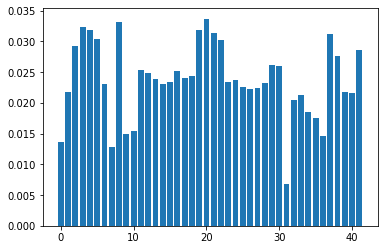

In [117]:
model = ExtraTreesClassifier()
model.fit(x_2_train, y_2_train)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

pruebas con valores por default

In [118]:
start = time.time()
light_model = LGBMClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
n_scores = cross_val_score(light_model, x_2_train, y_2_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()


print('Accuracy: %.3f (std :%.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end-start)/60))

Accuracy: 0.712 (std :0.016). Time: 0.23


# Grid search con los mejores parámetros anteriores

In [ ]:
light_model = LGBMClassifier(random_state = 1)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

n_estimators = n_estimators_df.nlargest(4,'accuracy').index.tolist() 
learning_rate = learning_rate_df.nlargest(4,'accuracy').index.tolist() 
subsample = subsample_df.nlargest(3,'accuracy').index.tolist()
num_leaves = num_leaves_df.nlargest(3,'accuracy').index.tolist()
max_depth = max_depth_df.nlargest(3,'accuracy').index.tolist()
min_split_gain_leaf = min_split_gain_df.nlargest(3,'accuracy').index.tolist()


grid = {
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_split_gain_leaf': min_split_gain_leaf,
               'num_leaves': num_leaves,
               'subsample': subsample}
start = time.time()
grid_serch_CV_3 = GridSearchCV(estimator = light_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
grid_serch_CV_3.fit(x_2_train, y_2_train)
end = time.time()

In [ ]:
print((end-start)/3600)
pd.DataFrame(grid_serch_CV_3.cv_results_).nlargest(10,'mean_test_score')

# Pruebas eliminando features

Eliminando una sola columna

In [28]:
x_train_columns = {}

for x in range(0,len(x_2_train.columns)):
    column_list = []
    for y in range(0,len(x_2_train.columns)):
        if y != x:
            column_list.append(y)
    x_train_columns[x] = column_list

In [29]:
no_column = get_dic_acc()
index_no_column = []


for x in range(0,len(x_2_train.columns)):
    start = time.time()

    light_model = LGBMClassifier(random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)
    x_2_train_2 = x_2_train.iloc[:,x_train_columns[x]]
    n_scores = cross_val_score(light_model, x_2_train_2, y_2_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    index_no_column.append(x_2_train.columns[x])
    no_column['accuracy'].append(np.mean(n_scores))
    no_column['std'].append(np.std(n_scores))
    no_column['time'].append((end - start)/60)

one_column_deleted = pd.DataFrame(no_column, index=index_no_column) 


In [30]:
one_column_deleted.nlargest(10,'accuracy')

,accuracy,std,time
total_7_words,0.731199,0.015945,0.175553
total_6_ormore_words,0.730837,0.014928,0.176326
total_5_orless_words,0.730772,0.015703,0.169900
text_best_similarity_location,0.730657,0.015656,0.176485
total_4_ormore_words,0.730542,0.015892,0.174773
len_location_cero_default,0.730427,0.014328,0.178933
total_upper_chars,0.730263,0.015400,0.180205
total_6_orless_words,0.730131,0.017886,0.182965
contain_hashtag,0.730000,0.014951,0.185678
total_3_ormore_words,0.729918,0.016253,0.185775


Eliminando dos columnas

In [32]:
def get_all_two_columns(column_list):
    two_columns_list = []
    for x in range(0,len(column_list)):
        for y in range(1,len(column_list)-x):
            columns = []
            columns.append(column_list[x])
            columns.append(column_list[x+y])
            two_columns_list.append(columns)
    return two_columns_list
            

In [33]:
no_column = get_dic_acc()
index_no_column = []

columns_to_delete_list = get_all_two_columns(range(0,len(x_2_train.columns)))

for x in columns_to_delete_list:
    start = time.time()

    light_model = LGBMClassifier(random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)
    x_2_train_2 = x_2_train.drop(columns= x_2_train.iloc[:,x].columns.tolist())
    n_scores = cross_val_score(light_model, x_2_train_2, y_2_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    index_no_column.append(", ".join(x_2_train.iloc[:,x].columns.tolist()))
    no_column['accuracy'].append(np.mean(n_scores))
    no_column['std'].append(np.std(n_scores))
    no_column['time'].append((end - start)/60)

two_column_deleted = pd.DataFrame(no_column, index=index_no_column) 

In [69]:
two_column_deleted.nlargest(10,'accuracy')

,accuracy,std,time
"total_6_orless_words, subjectivity_text",0.732562,0.016187,0.158562
"subjectivity_text, text_best_similarity_location",0.732250,0.016499,0.156382
"text_similarity_location, text_best_similarity_location",0.732036,0.015768,0.166033
"total_common_chars, total_4_words",0.731823,0.017137,0.165270
"total_4_ormore_words, subjectivity_text",0.731724,0.015787,0.158264
"total_7_words, text_similarity_location",0.731675,0.016149,0.166719
"total_4_orless_words, len_location_mean_default",0.731675,0.016707,0.167279
"total_7_words, total_8_words",0.731626,0.016029,0.169751
"total_7_words, subjectivity_text",0.731609,0.015812,0.159254
"total_4_words, total_8_words",0.731576,0.016034,0.170151


Se toman 10 de los features en cuya ausencia en la prueba  anterior no empeoró los resultados y se hacen pruebas eliminando todas las combinaciones posibles de estos 10 features

In [74]:
def subconjuntos(c):
    if len(c) == 0:
        return [[]]
    r = subconjuntos(c[:-1])
    return r + [s + [c[-1]] for s in r]

bad_columns = subconjuntos(['total_6_orless_words', 'subjectivity_text', 'text_best_similarity_location','text_similarity_location','total_common_chars', 'total_4_words','total_4_ormore_words','total_7_words','total_4_orless_words', 'len_location_mean_default'])
bad_columns.remove([])


In [75]:
no_column = get_dic_acc()
index_no_column = []

for x in bad_columns:
    start = time.time()

    light_model = LGBMClassifier(random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)
    x_2_train_2 = x_2_train.drop(columns= x)
    n_scores = cross_val_score(light_model, x_2_train_2, y_2_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    index_no_column.append(", ".join(x))
    no_column['accuracy'].append(np.mean(n_scores))
    no_column['std'].append(np.std(n_scores))
    no_column['time'].append((end - start)/60)

all_bad_column_deleted = pd.DataFrame(no_column, index=index_no_column) 


In [76]:
all_bad_column_deleted.nlargest(10,'accuracy')

,accuracy,std,time
"subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_words, total_4_ormore_words, total_7_words, total_4_orless_words, len_location_mean_default",0.735222,0.015931,0.150535
"subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_ormore_words, total_7_words, total_4_orless_words, len_location_mean_default",0.735172,0.014615,0.144412
"subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_words, total_7_words, total_4_orless_words, len_location_mean_default",0.735090,0.014833,0.143564
"total_6_orless_words, subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_words, total_7_words, total_4_orless_words, len_location_mean_default",0.734762,0.015493,0.149217
"subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_words, total_4_ormore_words, total_7_words, len_location_mean_default",0.734663,0.016667,0.145873
"total_6_orless_words, subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_words, total_4_ormore_words, total_7_words, total_4_orless_words, len_location_mean_default",0.734647,0.015384,0.138616
"total_6_orless_words, subjectivity_text, text_best_similarity_location, text_similarity_location, total_common_chars, total_4_words, total_7_words, total_4_orless_words, len_location_mean_default",0.734614,0.015629,0.141391
"subjectivity_text, text_best_similarity_location, text_similarity_location, total_4_ormore_words, total_7_words, len_location_mean_default",0.734516,0.016164,0.147075
"subjectivity_text, text_similarity_location, total_4_words, total_4_ormore_words, total_7_words, len_location_mean_default",0.734401,0.015730,0.147504
"total_6_orless_words, subjectivity_text, text_best_similarity_location, total_4_words, total_4_ormore_words, total_7_words, len_location_mean_default",0.734351,0.016236,0.146812


In [ ]:
Eliminar los features correspondientes 

In [157]:
for x in x_2_train.join(tweets_2.loc[:,['text','target']]).loc[:,['text','target']].iterrows():
    print(x[1]['text'])

Turkish troops killed in Kurdish militant 'suicide attack' http://t.co/7cIbxls55f
@AisuMage @AkumaReisu --just between Gray and Ophelia red flames blazing around her person setting nearly everything in the area--
#tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm
Truly a scene of chaos unprecedented in frenzy. Pandemonium even. Utter disorder. That anyone survived such mania is astounding. @catovitch
Everything has sunk in except the fact that I am actually moving to the state of Colorado tomorrow. Been dreaming of it since I was a kid.??
Don't let your style fall flat this summer! Lord &amp; Cliff #thinkpink #magichairbump is your answer. Adding this... http://t.co/NmHZTB1ewM
Discovered Plane Debris Is From Missing Malaysia Airlines Flight 370 | TIME http://t.co/7fSn1GeWUX
@Catwoman1775 Another shooting in a movie theater this is getting more crazier but I'm glad they got the shooter &amp; no casualties.
W

@FunkyLilShack @mariaf30 I want a full on bitch slapping guns blazing cake throwing Charles showdown!! Now THAT will be worth the wait ????
LRT refer to the lyrics to hear Big Boi explain why heÛªs as cool as ÛÏsippinÛª a milkshake in a snowstorm' lame bars but effective at the time
Landslide in Italian Alps kills three - ROME (Reuters) - Three people were killed when a severe rainstorm in the I... http://t.co/BoygBp0Jw9
Simmering beneath #NHL good times the league's own concussion issues @PioneerPress

http://t.co/zl7FhUCxHL
|| So.... I just watched the trailed for The Dust Storm and I think part of me just died.... Colin is so perfect my goodness.
It's getting to be hazardous getting into this world alive. https://t.co/BJZSSw4tid
The famine is coming to an end #Bluebell http://t.co/p9ryMfjcUX
Following a catastrophic injury acute medical care takes precedent.  PTSD often follows in it's wake undetected... http://t.co/BZkqpl6R0a
?#FUKUSHIMA?#TEPCO?
Fukushima Nuclear Disaster | Incr

 Twi... http://t.co/RYEQMxIrj8 #manchesterlite
Sirens everywhere!
0nPzp mhtw4fnet

Officials: Alabama Home Quarantined Over Possible Ebola Case - ABC News
Wyrmwood: Road of the Dead (2014) was fucking awesome and it had an awesome ending too. Awesome one.
Patriot Survival Guide: Do you know how survive when the governments collapse or other natural disaster happens? http://t.co/QhtoerhDkM
forever drowning in my feelings.
Myanmar Flooding: Heavy monsoon rains during the month of July have caused flooding flash floods and landsli... http://t.co/9TG7A5OqFP
UNPREDICTABLE DISCONNECTED AND SOCIAL CASUALTY ARE MY FAVORITES HOW DO PEOPLE NOT LIKE THEM
AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/4evTTqPEia
#Tigers Wonder how much the upheaval with team is affecting different players tonight?
@mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best.
EPA begins demolition of homes

Suicide bomber detonates in Saudi Arabia mosque 17 reportedly killed  http://t.co/xycKgxZv9s
Gail and Russell saw lots of hail at their Dalroy home - they have video of twister 1/2 mile from their home #yyc http://t.co/3VfKEdGrsO
Womens Buckle Casual Stylish Shoulder Handbags Pockets Cross Body Bags Green http://t.co/Jqso4fyZp4 http://t.co/F4XnPliO5S
Get å£150 free bets when you register at Boylesports Casino #Luck #Destroy http://t.co/zildpvKNXP http://t.co/5yDb4s13pF
@Adanne___ kindly follow back
ChinaÛªs stock market crash this summer has sparked interest from bargain hunters and bulls betting on a rebound. DÛ_ http://t.co/1yggZziZ9o
L B #Entertainment lot of 8 #BruceWillis MOVIES #DVD DIE HARD 1 2 12 MONKEYS ARMAGEDDON SIXTH #eBay #Auction http://t.co/CxDJApzXMP
To Supply and Install New FRP Emergency Slide  at Tunas KijangBank Negara Malaysia [Closing Date: 2015-08-14]... http://t.co/ZpqwKHFhNf
Severe Thunderstorm Warning for Oklahoma County in OK until 10:30pm CDT. #okwx
Bloody

@TheTshirtKid I'm tryna smoke that MF out
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/M4TcZaawpT
First responders would never be sent to the wrong address again w/ #SmartTek's GPS-based panic button #mPERS #safety http://t.co/3OionqlFQL
Only one commodity has escaped the total collapse in prices http://t.co/4HngTKDQMv #business
@spinningbot Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.
Hail The New Caesars! http://t.co/GzMoBlsJxu http://t.co/5CGtqfk2uR
thunder is legit
@DalaiLama then have the biggest nuclear disaster to ever have happened
SEISMIC RISK: a COMPARISON between 2 case studies: CALABRIA AND MALTA http://t.co/HmRtqEykyI
A memorial to the millions who perished in the Holodomor has been erected in the U.S. capital. http://t.co/Dj1LWZNIEH http://t.co/I9MxXkzHbL
Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/O4xLjnaV8F
Strict liability in the 

40 displaced by Ocean Township apartment fire #NewYork - http://t.co/uelZ59wVOm
In 2014 I will only smoke crqck if I becyme a mayor. This includes Foursquare.
New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/BLAAWHYScT http://t.co/dDR0zjXVQN
The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr
Gotta love #summer in #Calgary. #yyc #hailstorm #crazyweather http://t.co/xQbWnLBBIu
Homemade frozen yogurt pops? Have you had luck making them? http://t.co/YzaZF4CEOa http://t.co/X5RC5Nuamh
i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore
This weekend is me and Nathan's birthday weekend so if you want to drown yourself in beer do reckless things and potentially die hmu
Smoke detectors not required in all buildings: An office building on Shevlin-Hixon Drive was on fire. There we... http://t.co/z6Ee1jVhNi
Why did God order obliter

Oops: Bounty hunters try to raid Phoenix police chief's home http://t.co/u30n3fFX8Y
Trouble trouble when I don't get my way ????
Thanks a lot roadworks men cos a tube strike wasn't disruptive enough so having to walk the desolate route from Tottenham to .....
@joshacagan Your only option now is to move to an desolate island with nothing but a stack of DVDs you canÛªt watch.
'Cooler than Freddie Jackson sippin' a milkshake in a snowstorm'
I liked a @YouTube video http://t.co/YdgiUYdqgb Mini Pony packs a punch. Live report from the Salem County Fair on CBS3 Eyewitness
Be ember aware! http://t.co/LZmL1xB2nH
@selmoooooo @_edvinnn @imTariik @dzafic_haris selmo u not catching flames from me  im just gonna be witnessing the slaughter
Revel in yours wmv videos by means of mac farewell ablaze wmv en route to dvd: GtxRWm
Tarp is protecting outfield and cannot be moved. Infield getting deluged.
Cleveland Heights Shaker Heights fight blight: The House Next Door http://t.co/wYOKt0ftRw
Army names 1

Siguiendo la linea del TP1, sabemos que hay palabras más frecuentes en tweets verdaderos. No es posible usar las encontradas en el TP1 debido a que estos features tienen conocimiento del target y corresponden al mismo set que se dividió train y test set, por lo tanto generaremos unos nuevos a partir del train set. 

In [261]:
words_dict = {}
for x in x_2_train.join(tweets_2.loc[:,['text','target']]).loc[:,['text','target']].iterrows():
    for word in re.split(' |\'|\*|\n|:|#|@|-|\?|\.|,|[|]|!|¡',x[1]['text']):
        word = word.lower()
        if len(word) < 4:
            continue
        if not word in words_dict:
            words_dict[word] = [0,0]
        if x[1]['target'] == 1:
            words_dict[word][0] = words_dict[word][0] + 1
        else:
            words_dict[word][1] = words_dict[word][1] + 1

            

In [264]:
words_df = pd.DataFrame(words_dict,index=['total_target_true','total_target_false']).transpose()
words_df = words_df.loc[(words_df.total_target_true + words_df.total_target_false) > 10]

In [ ]:
words_100_true = []
words_100_false = []
words_80_true = []



for x in words_df.iterrows():
